# Assignment3
Repository Link: [Github](https://github.com/awakn123/CS6120NLP/tree/main)

Members: Yun Cao, Yue Liu, Nan Chen, Muyang Cheng

# Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [2]:
# data link: https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
import pandas as pd
import json

data = []
with open('./Clothing_Shoes_and_Jewelry_5.json'
            , 'r') as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)
#df = df.sample(1000)
print(df.head())

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  
0  Great tutu-  not cheaply made      1297468800  02 12, 2011  
1                    Very Cute!!      1358553600  01 19, 201

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, and other tasks as
you deem necessary.

In [3]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    text = text.strip()
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

df["reviewText2"] = df["reviewText"].apply(lambda x: clean_text(x))
df["summary2"] = df["summary"].apply(lambda x: clean_text(x))

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/2438883267.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caoyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/caoyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Part 2: Word2Vec, fasttext embeddings
2.1 Create 100D vectors using both Word2Vec (CBOW and SkipGram separately), and fasttext algorithms

In [4]:
from gensim.models import Word2Vec
from gensim.models import FastText

sentences = [review.split() for review in df["reviewText2"]]

# Word2Vec CBOW Model
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
#cbow_model.save("cbow_word2vec.model")

# Word2Vec Skip-gram Model
skipgram_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)
#skipgram_model.save("skipgram_word2vec.model")

# FastText Model
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=1, sg=1)
#fasttext_model.save("fasttext.model")


2.2 Average the vectors to create new average vector columns in the df

In [5]:
import numpy as np
def get_average_word2vec_embeddings(review, model):
    words = review.split()
    embeddings = [model.wv[word] for word in words if word in model.wv.key_to_index]
    if len(embeddings) == 0:
        return [0]*model.vector_size
    return list(np.mean(embeddings, axis=0))

df_cbow_model = df.copy()
embeddings = df_cbow_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, cbow_model))
for i in range(cbow_model.vector_size):
    df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i]) 
print(df_cbow_model.head())

df_skipgram_model = df.copy()
embeddings = df_skipgram_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, skipgram_model))
for i in range(skipgram_model.vector_size):
    df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
print(df_skipgram_model.head())

df_fasttext_model = df.copy()
embeddings = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model))
for i in range(fasttext_model.vector_size):
    df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
print(df_fasttext_model.head())

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usual

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:18: PerformanceWarning: DataFrame is highly fragmented.  This 

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])


       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/112724244.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model[f"w2v_emb_{i}"] = embeddings.apply(lambda x: x[i])


2.3 Perform EDA to analyze associations between vectors from the three methods above.


Analyze Words


In [6]:
# Select 100 common words in three models
words = list(cbow_model.wv.key_to_index.keys())[:100]

# Extract the vectors for these common words from each model
cbow_vectors = np.array([cbow_model.wv[word] for word in words])
skipgram_vectors = np.array([skipgram_model.wv[word] for word in words])
fasttext_vectors = np.array([fasttext_model.wv[word] for word in words])

In [7]:
# Visualization with t-SNE
#Use t-SNE to reduce the dimensionality of your word vectors to two or three dimensions.
#Plot the results to see how words cluster together.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_word_vectors(model_vectors, words, title='Word Vectors Visualization'):
    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(model_vectors)
    plt.figure(figsize=(12, 12))
    for i, word in enumerate(words):
        plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1])
        plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(title)

visualize_word_vectors(cbow_vectors, words, 'CBOW t-SNE Visualization')
visualize_word_vectors(skipgram_vectors, words, 'Skip-gram t-SNE Visualization')
visualize_word_vectors(fasttext_vectors, words, 'FastText t-SNE Visualization')
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

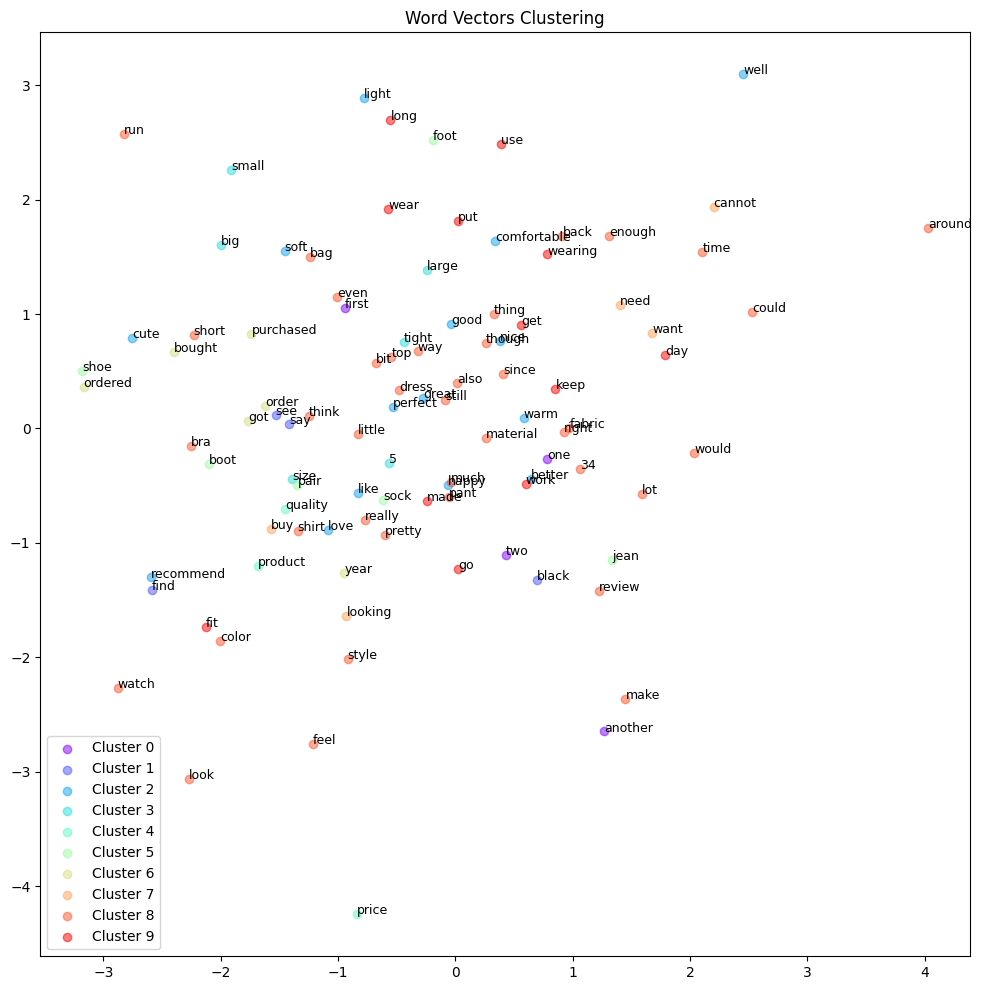

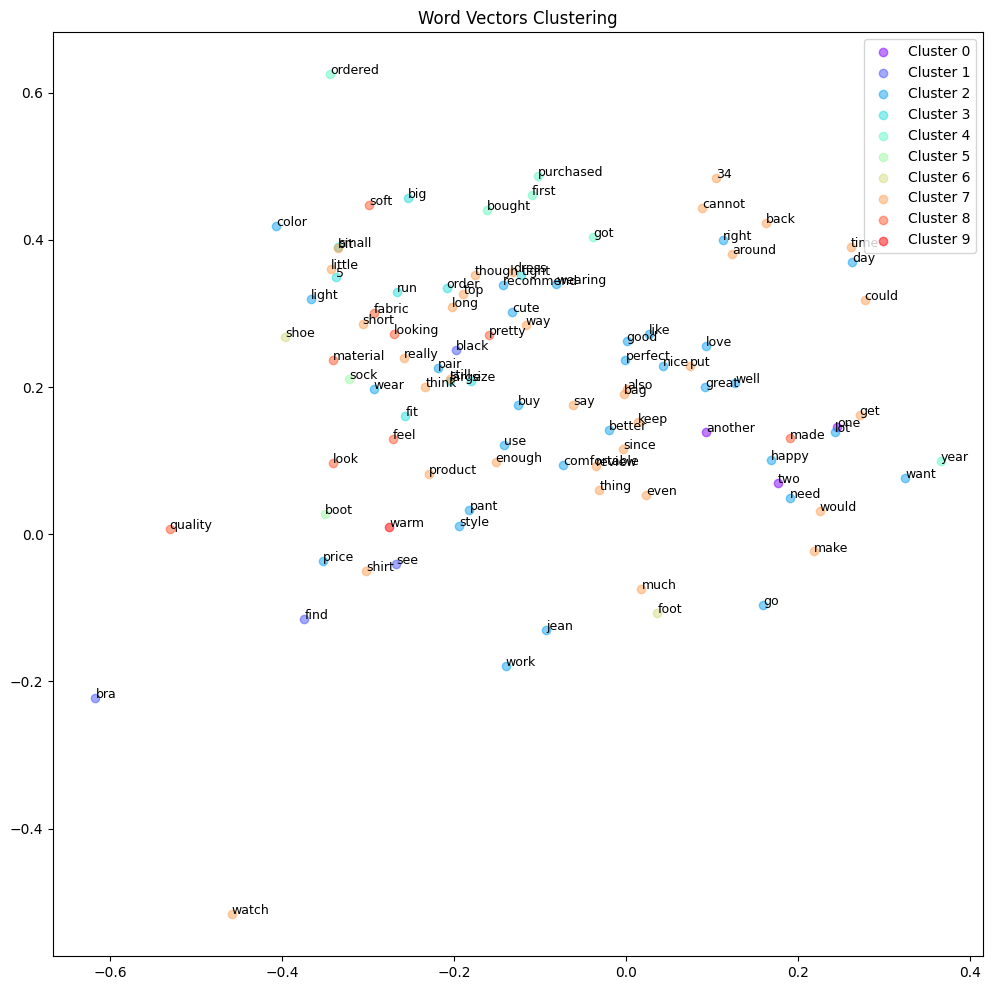

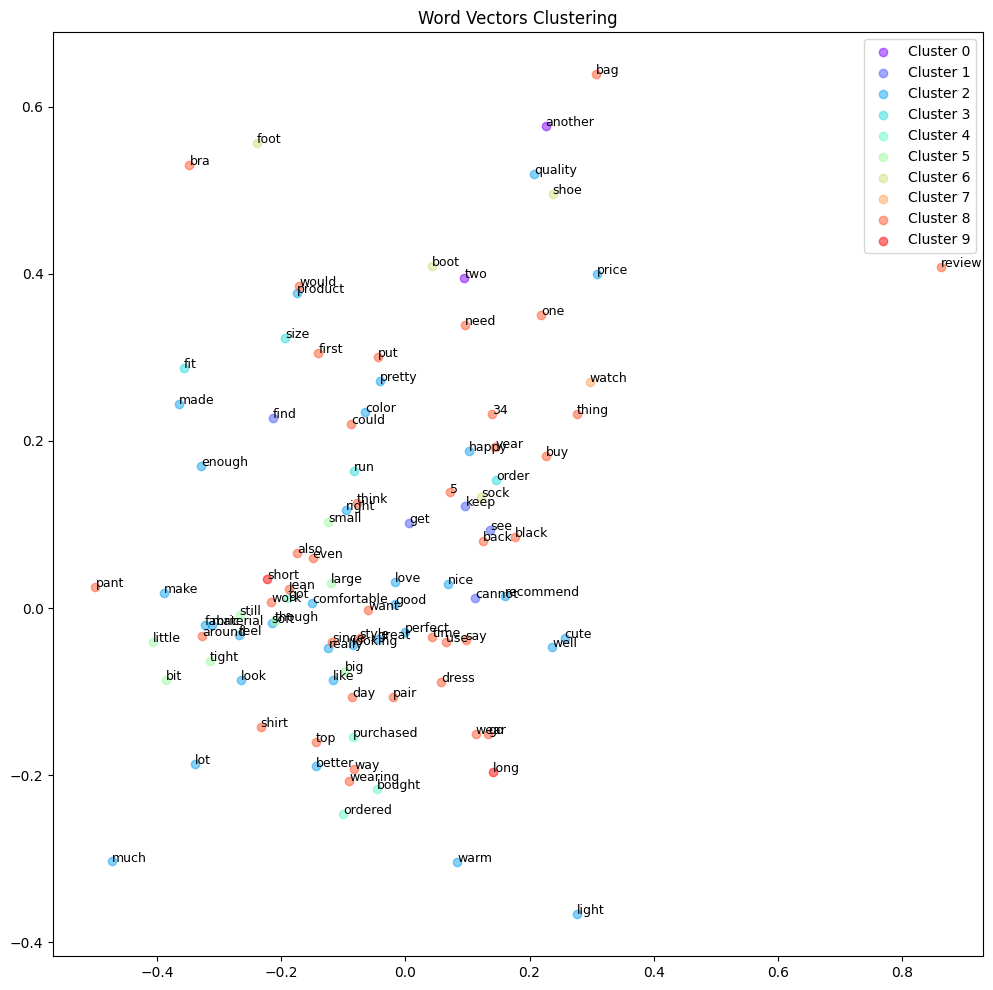

In [ ]:
# Clustering with KMeans
# Apply clustering algorithms like K-Means on the word vectors.
# Analyze the clusters to see which words are grouped together by the model.
from sklearn.cluster import KMeans


def cluster_and_plot_words(model_vectors, common_words, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(model_vectors)
    cluster_map = {i: [] for i in range(n_clusters)}
    for word, label in zip(common_words, labels):
        cluster_map[label].append(word)

    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    plt.figure(figsize=(12, 12))
    
    for cluster_id in range(n_clusters):
        cluster_indices = [i for i, label in enumerate(labels) if label == cluster_id]
        cluster_points = model_vectors[cluster_indices]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.5)
    
    for i, word in enumerate(common_words):
        plt.text(model_vectors[i, 0], model_vectors[i, 1], word, fontsize=9)
    
    plt.title('Word Vectors Clustering')
    plt.legend()
    plt.show()
    
    return cluster_map

cbow_clusters = cluster_and_plot_words(cbow_vectors, words, n_clusters=10)
skipgram_clusters = cluster_and_plot_words(skipgram_vectors, words, n_clusters=10)
fasttext_clusters = cluster_and_plot_words(fasttext_vectors, words, n_clusters=10)

In [ ]:
# Similarity Analysis
# Compute the cosine similarity between word vectors
from scipy.spatial.distance import cosine

def compare_similarity(word1, word2, model1, model2, model3, model_name1='CBOW', model_name2='Skip-gram', model_name3='FastText'):
    similarity1 = 1 - cosine(model1.wv[word1], model1.wv[word2])
    similarity2 = 1 - cosine(model2.wv[word1], model2.wv[word2])
    similarity3 = 1 - cosine(model3.wv[word1], model3.wv[word2])
    print(f'{word1} & {word2} similarity in {model_name1}: {similarity1:.4f}')
    print(f'{word1} & {word2} similarity in {model_name2}: {similarity2:.4f}')
    print(f'{word1} & {word2} similarity in {model_name3}: {similarity3:.4f}')

compare_similarity('shirt', 'hoodie', cbow_model, skipgram_model, fasttext_model)


shirt & hoodie similarity in CBOW: 0.7055
shirt & hoodie similarity in Skip-gram: 0.7914
shirt & hoodie similarity in FastText: 0.7782


# Part 3: Sentiment Analysis

In [10]:


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Convert the ratings to 0 for negative and 1 for positive
def convert_rating_to_sentiment(overall):
  if overall in [1, 2]:
      return 0  # Negative sentiment
  elif overall in [4, 5]:
      return 1  # Positive sentiment
  # Optionally handle unexpected cases, though all cases should be covered
  return None

def convertAndReduceDimension(df):
		df_filtered = df[df['overall'] != 3]
		df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
		vector_cols = [col for col in df_filtered.columns if col.startswith('w2v_emb_')]
		X = df_filtered[vector_cols]
		scaler = StandardScaler()
		X_scaled = scaler.fit_transform(X)

		# Step 2: Apply PCA to retain 90% of the variance
		pca = PCA(n_components=0.9)  # n_components set to 0.9 means PCA will select the minimum number of components that retain 90% of the variance
		X_pca = pca.fit_transform(X_scaled)

		# Create a DataFrame with the PCA features
		df_pca = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])

		# Optionally, if you want to include the sentiment back into the PCA-transformed dataset
		df_pca['sentiment'] = df_filtered['sentiment'].values

		return df_pca
  
df_cbow = convertAndReduceDimension(df_cbow_model)
df_skipgram = convertAndReduceDimension(df_skipgram_model)
df_fasttext = convertAndReduceDimension(df_fasttext_model)

# Define your DataFrame to hold the results
results_df = pd.DataFrame(columns=['model', 'data_model', 'accuracy', 'precision', 'f1-score', 'tpr', 'fpr', 'auc'])

/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/1889851742.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/1889851742.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['overall'].apply(convert_rating_to_sentiment)
/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_56324/1889851742.py:18: PerformanceW

### RNN Model

At first I tried to train with only one SimpleRNN layer, and then found its accuracy exceeds 80%, approximate 90%, which is a really good result. However, the fpr is very high too, and auc is only 0.5. After studying, I found the reason is we have an unblanced dataset, which holds 20% 0(overal 1,2) and 80% 1(overal 4,5). So most of train effect drops in the positive part, and the negative part are ignored during the training.

After searching, a parameter ```class_weight``` appeared. It could help us balance the data by the serenity, and see the real effect on both sides. I applied it immediately. Sure enough, the accuracy drops to around 50%, and tpr and fpr are around 50% too. It shows a good and reasonable result.

|      | model | data_model | accuracy | precision | f1-score |      tpr |      fpr |      auc |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: | -------: | -------: |
|    1 |   RNN |       cbow | 0.595013 |  0.918354 | 0.726556 | 0.601030 | 0.456380 | 0.572325 |
|    2 |   RNN |   skipgram | 0.445067 |  0.915617 | 0.574609 | 0.418678 | 0.329554 | 0.544562 |
|    3 |   RNN |   fasttext | 0.607541 |  0.944446 | 0.731331 | 0.596688 | 0.299769 | 0.648459 |


Then I tried to apply the LSTM layer instead of Simple RNN. It runs a long time more than 3 hours, and get a result like below:

|      | model | data_model | accuracy | precision | f1-score |      tpr |      fpr |      auc |
| ---: | ----: | ---------: | -------: | --------: | -------: | -------: | -------: | -------: |
|    1 |   RNN |       cbow | 0.816761 |  0.982817 | 0.887754 | 0.809458 | 0.120869 | 0.844295 |
|    2 |   RNN |   skipgram | 0.872027 |  0.978039 | 0.924617 | 0.876730 | 0.168140 | 0.854295 |
|    3 |   RNN |   fasttext | 0.104812 |  0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.500000 |

The accuracy of cbow and skipgram improves significantly, but fasttext is verylow. Though it is fascinating on the reason, considering the time consumption, I will not divulge deeply on it and will use the Simple RNN layer as the final model.

During my studying and searching, there is a voice saying that not using the cbow average vectors directly, but using an Embedded layer would be better. The reason they gave is the average vectors would lose information within the sentence, and pre-trained word embeddings will perform better. It seems reasonable, so I mark it in there, but it is out of our scope obliviously.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight

def train_with_rnn(df, data_type):
	# Assuming df_final is your final DataFrame after PCA
	X = df.drop('sentiment', axis=1).values  # Features
	y = df['sentiment'].values  # Labels

	# Splitting the data into training and validation sets
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
	# Reshaping the data to fit RNN input requirements: [samples, time steps, features]
	# Here, we assume 1 feature per time step for simplicity
	X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
	X_val_rnn = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

	class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
	class_weight_dict = dict(enumerate(class_weights))
	print(class_weight_dict)

	# Define the RNN model
	model = Sequential([
	    SimpleRNN(128),  # RNN layer with 128 units
			# LSTM(128, return_sequences=True),  # LSTM layer with 128 units, returning sequences for context
  		# LSTM(64),  # Another LSTM layer with 64 units
	    Dense(64, activation='relu'),
	    Dropout(0.5),
	    Dense(1, activation='sigmoid')
	])

	model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
	history = model.fit(X_train_rnn, y_train, class_weight=class_weight_dict, epochs=10, batch_size=64, validation_data=(X_val_rnn, y_val))
	# Evaluate the model on the validation set
	val_loss, val_accuracy = model.evaluate(X_val_rnn, y_val)
	predictions = model.predict(X_val_rnn)
	predictions_binary = [1 if prob > 0.5 else 0 for prob in predictions]
	

	# Assuming `y_val` are the true labels and `predictions_binary` are the binary predictions from the RNN model
	accuracy = accuracy_score(y_val, predictions_binary)
	precision = precision_score(y_val, predictions_binary)
	recall = recall_score(y_val, predictions_binary)  # Same as TPR
	f1 = f1_score(y_val, predictions_binary)
	auc = roc_auc_score(y_val, predictions_binary)

	# Calculate FPR
	tn, fp, fn, tp = confusion_matrix(y_val, predictions_binary).ravel()
	fpr = fp / (fp + tn)

	# Append new results
	metrics_dict = {
	    'model': 'RNN',
	    'data_model': data_type,
	    'accuracy': accuracy,
	    'precision': precision,
	    'f1-score': f1,
	    'tpr': recall,
	    'fpr': fpr,
	    'auc': auc
	}
	return metrics_dict, model

import datetime
print(datetime.datetime.now())
# results_df = pd.DataFrame(columns=['model', 'data_model', 'accuracy', 'precision', 'f1-score', 'tpr', 'fpr', 'auc'])
cbow_data, rnn_cbow_model = train_with_rnn(df_cbow, 'cbow')
results_df = results_df._append(cbow_data, ignore_index=True)
skipgram_data, rnn_skipgram_model = train_with_rnn(df_skipgram, 'skipgram')
results_df = results_df._append(skipgram_data, ignore_index=True)
fasttext_data, rnn_fasttext_model = train_with_rnn(df_fasttext, 'fasttext')
results_df = results_df._append(fasttext_data, ignore_index=True)
display(results_df)
print(datetime.datetime.now())

2024-03-09 19:32:30.055121
{0: 4.629178126893851, 1: 0.5605447360993508}
Epoch 1/10
3104/3104 [==============================] - 82s 26ms/step - loss: 0.6709 - accuracy: 0.5468 - val_loss: 0.6445 - val_accuracy: 0.5365
Epoch 2/10
3104/3104 [==============================] - 79s 25ms/step - loss: 0.6869 - accuracy: 0.4646 - val_loss: 0.6984 - val_accuracy: 0.5116
Epoch 3/10
3104/3104 [==============================] - 141s 45ms/step - loss: 0.6925 - accuracy: 0.4206 - val_loss: 0.6923 - val_accuracy: 0.2406
Epoch 4/10
3104/3104 [==============================] - 91s 29ms/step - loss: 0.6873 - accuracy: 0.4634 - val_loss: 0.7059 - val_accuracy: 0.3127
Epoch 5/10
3104/3104 [==============================] - 71s 23ms/step - loss: 0.6824 - accuracy: 0.4629 - val_loss: 0.6961 - val_accuracy: 0.3301
Epoch 6/10
3104/3104 [==============================] - 114s 37ms/step - loss: 0.6829 - accuracy: 0.5198 - val_loss: 0.7482 - val_accuracy: 0.6629
Epoch 7/10
3104/3104 [===========================

,model,data_model,accuracy,precision,f1-score,tpr,fpr,auc
0,RNN,cbow,0.556162,0.908912,0.693287,0.560353,0.479631,0.540361
1,RNN,skipgram,0.452519,0.917691,0.582526,0.426688,0.326864,0.549912
2,RNN,fasttext,0.440716,0.926984,0.565953,0.407317,0.274020,0.566648
3,RNN,cbow,0.816761,0.982817,0.887754,0.809458,0.120869,0.844295
4,RNN,skipgram,0.872027,0.978039,0.924617,0.876730,0.168140,0.854295
5,RNN,fasttext,0.104812,0.000000,0.000000,0.000000,0.000000,0.500000
6,RNN,cbow,0.595013,0.918354,0.726556,0.601030,0.456380,0.572325
7,RNN,skipgram,0.445067,0.915617,0.574609,0.418678,0.329554,0.544562
8,RNN,fasttext,0.607541,0.944446,0.731331,0.596688,0.299769,0.648459


2024-03-09 20:07:11.364998
